In [527]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [528]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

In [529]:
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')

# Get the first 85000 rows
df = df.tail(8000)
df

NoticeId,Title,Sol#,Department/Ind.Agency,CGAC,Sub-Tier,FPDS Code,Office,AAC Code,PostedDate,Type,BaseType,ArchiveType,ArchiveDate,SetASideCode,SetASide,ResponseDeadLine,NaicsCode,ClassificationCode,PopStreetAddress,PopCity,PopState,PopZip,PopCountry,Active,AwardNumber,AwardDate,Award$,Awardee,PrimaryContactTitle,PrimaryContactFullname,PrimaryContactEmail,PrimaryContactPhone,PrimaryContactFax,SecondaryContactTitle,SecondaryContactFullname,SecondaryContactEmail,SecondaryContactPhone,SecondaryContactFax,OrganizationType,State,City,ZipCode,CountryCode,AdditionalInfoLink,Link,Description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""82bac2ce027f429c82e9fedbeaa4c1…","""REDSTONE ARSENAL JOB ORDER CON…","""15F06721D0004076""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL BUREAU OF INVESTIGATIO…","""1549""","""FBI-JEH""","""15F067""","""2021-10-13 13:06:42.329-04""","""Award Notice""","""Award Notice""","""autocustom""","""2021-10-31""","""SBA""","""Total Small Business Set-Aside…","""""","""236220""","""5680""","""""","""Huntsville""","""AL""","""35895""","""USA""","""No""","""15F06721D00004076""","""2021-09-29""","""35000000.00""","""GSE-Leebcor JV1, LLC VA 22312-…","""""","""ANDRE WILSON""","""ALWILSON6@FBI.GOV""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""20535""","""USA""","""""","""https://sam.gov/opp/82bac2ce02…",""""""
"""c580d478056e4771ae2731faaab848…","""Renovate BEQ, Building 2701, N…","""N44255-22-R-2001""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVFAC NORTHWEST""","""N44255""","""2021-10-13 13:06:36.489-04""","""Presolicitation""","""Presolicitation""","""autocustom""","""2021-11-01""","""""","""""","""2021-11-01T10:00:00-04:00""","""236220""","""Z2FC""","""""","""Oak Harbor""","""WA""","""98278""","""USA""","""No""","""""","""""","""""","""""","""""","""Liliana Sanchez""","""liliana.m.sanchez.civ@us.navy.…","""3603960237""","""""","""""","""JoAnna Lovett-Black""","""joanna.lovett-black@navy.mil""","""3603155003""","""""","""OFFICE""","""WA""","""SILVERDALE""","""98315-1101""","""USA""","""""","""https://sam.gov/opp/c580d47805…","""Pre-Solicitation Notice for a …"
"""8a1b125a41ad4a07a14465526559b3…","""REDSTONE ARSENAL JOB ORDER CON…","""15F06721D0004076""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL BUREAU OF INVESTIGATIO…","""1549""","""FBI-JEH""","""15F067""","""2021-10-13 13:05:47.45-04""","""Award Notice""","""Award Notice""","""autocustom""","""2021-10-31""","""SBA""","""Total Small Business Set-Aside…","""""","""236220""","""5680""","""""","""Huntsville""","""AL""","""35895""","""USA""","""No""","""15F06721D00004076""","""2021-09-29""","""35000000.00""","""GSE-Leebcor JV1, LLC VA 22312-…","""""","""ANDRE WILSON""","""ALWILSON6@FBI.GOV""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""20535""","""USA""","""""","""https://sam.gov/opp/8a1b125a41…",""""""
"""fb588e8c665449b48895d5d8d32db8…","""Request for Proposal (RFP) # 9…","""95900621R0005""","""MORRIS K UDALL SCHOLARSHIP AND…",487,"""MORRIS K UDALL SCHOLARSHIP AND…","""9545""","""MORRIS K UDALL FOUND US INST""","""959006""","""2021-10-13 13:05:36.578-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""auto15""","""2021-11-05""","""""","""""","""2021-10-21T14:00:00-06:00""","""541990""","""R499""","""""","""Tucson""","""AZ""","""85701""","""USA""","""No""","""""","""""","""""","""""","""""","""Terri L Harrison""","""harrison@udall.gov""","""520.901.8565""","""""","""""","""""","""""","""""","""""","""OFFICE""","""AZ""","""TUCSON""","""85701""","""USA""","""""","""https://sam.gov/opp/fb588e8c66…","""This is a Request for Proposal…"
"""5da0364853e14ac3887c7584d6f824…","""OR DOT CRGNSA 100(6), Historic…","""69056721B000016""","""TRANSPORTATION, DEPARTMENT OF""",69,"""FEDERAL HIGHWAY ADM

In [530]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)
df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""82bac2ce027f429c82e9fedbeaa4c1…","""REDSTONE ARSENAL JOB ORDER CON…","""15F06721D0004076""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL BUREAU OF INVESTIGATIO…","""1549""","""FBI-JEH""","""15F067""","""2021-10-13 13:06:42.329-04""","""Award Notice""","""Award Notice""","""autocustom""","""2021-10-31""","""SBA""","""Total Small Business Set-Aside…","""""","""236220""","""5680""","""""","""Huntsville""","""AL""","""35895""","""USA""","""No""","""15F06721D00004076""","""2021-09-29""","""35000000.00""","""GSE-Leebcor JV1, LLC VA 22312-…","""""","""ANDRE WILSON""","""ALWILSON6@FBI.GOV""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""20535""","""USA""","""""","""https://sam.gov/opp/82bac2ce02…",""""""
"""c580d478056e4771ae2731faaab848…","""Renovate BEQ, Building 2701, N…","""N44255-22-R-2001""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVFAC NORTHWEST""","""N44255""","""2021-10-13 13:06:36.489-04""","""Presolicitation""","""Presolicitation""","""autocustom""","""2021-11-01""","""""","""""","""2021-11-01T10:00:00-04:00""","""236220""","""Z2FC""","""""","""Oak Harbor""","""WA""","""98278""","""USA""","""No""","""""","""""","""""","""""","""""","""Liliana Sanchez""","""liliana.m.sanchez.civ@us.navy.…","""3603960237""","""""","""""","""JoAnna Lovett-Black""","""joanna.lovett-black@navy.mil""","""3603155003""","""""","""OFFICE""","""WA""","""SILVERDALE""","""98315-1101""","""USA""","""""","""https://sam.gov/opp/c580d47805…","""Pre-Solicitation Notice for a …"
"""8a1b125a41ad4a07a14465526559b3…","""REDSTONE ARSENAL JOB ORDER CON…","""15F06721D0004076""","""JUSTICE, DEPARTMENT OF""",15,"""FEDERAL BUREAU OF INVESTIGATIO…","""1549""","""FBI-JEH""","""15F067""","""2021-10-13 13:05:47.45-04""","""Award Notice""","""Award Notice""","""autocustom""","""2021-10-31""","""SBA""","""Total Small Business Set-Aside…","""""","""236220""","""5680""","""""","""Huntsville""","""AL""","""35895""","""USA""","""No""","""15F06721D00004076""","""2021-09-29""","""35000000.00""","""GSE-Leebcor JV1, LLC VA 22312-…","""""","""ANDRE WILSON""","""ALWILSON6@FBI.GOV""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""DC""","""WASHINGTON""","""20535""","""USA""","""""","""https://sam.gov/opp/8a1b125a41…",""""""
"""fb588e8c665449b48895d5d8d32db8…","""Request for Proposal (RFP) # 9…","""95900621R0005""","""MORRIS K UDALL SCHOLARSHIP AND…",487,"""MORRIS K UDALL SCHOLARSHIP AND…","""9545""","""MORRIS K UDALL FOUND US INST""","""959006""","""2021-10-13 13:05:36.578-04""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""auto15""","""2021-11-05""","""""","""""","""2021-10-21T14:00:00-06:00""","""541990""","""R499""","""""","""Tucson""","""AZ""","""85701""","""USA""","""No""","""""","""""","""""","""""","""""","""Terri L Harrison""","""harrison@udall.gov""","""520.901.8565""","""""","""""","""""","""""","""""","""""","""OFFICE""","""AZ""","""TUCSON""","""85701""","""USA""","""""","""https://sam.gov/opp/fb588e8c66…","""This is a Request for Proposal…"
"""5da0364853e14ac3887c7584d6f824…","""OR DOT CRGNSA 100(6), Historic…","""69056721B000016""","""TRANSPORTATION, DEPARTMENT OF""",69,"""FEDERAL HIGHWAY ADM

In [531]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 8000          ┆ 0              │
│ title                 ┆ 5491          ┆ 0              │
│ sol_                  ┆ 6865          ┆ 0              │
│ department_ind_agency ┆ 42            ┆ 0              │
│ cgac                  ┆ 43            ┆ 0              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 608           ┆ 0              │
│ countrycode           ┆ 18            ┆ 0              │
│ additionalinfolink    ┆ 1             ┆ 0              │
│ link                  ┆ 8000          ┆ 0              │
│ description           ┆ 6048          ┆ 0              │
└───────────────────────┴───────────────┴

In [532]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code', 'office', 'aac_code', 
                    'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 
                    'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 
                    'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 
                    'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 
                    'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 
                    'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 
                    'countrycode', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [533]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format

df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64
"""82bac2ce027f429c82e9fedbeaa4c1…",4464,315,20,15,40,28,301,112,7965,0,0,2,57,6,9,0,29,218,0,316,3,370,60,0,168,111,"""35000000.00""",396,0,21,21,0,0,0,0,0,0,0,3,11,357,124,15,"""""","""https://sam.gov/opp/82bac2ce02…",0
"""c580d478056e4771ae2731faaab848…",4573,2821,7,17,30,34,446,574,7964,3,4,2,58,0,0,827,29,815,0,485,53,866,60,0,0,0,"""""",0,0,1678,2104,648,0,0,450,570,249,0,3,52,325,593,15,"""""","""https://sam.gov/opp/c580d47805…",2008
"""8a1b125a41ad4a07a14465526559b3…",4464,315,20,15,40,28,301,112,7963,0,0,2,57,6,9,0,29,218,0,316,3,370,60,0,168,111,"""35000000.00""",396,0,21,21,0,0,0,0,0,0,0,3,11,357,124,15,"""""","""https://sam.gov/opp/8a1b125a41…",0
"""fb588e8c665449b48895d5d8d32db8…",4630,1488,24,487,62,91,384,376,7962,1,1,0,62,0,0,595,418,635,0,653,6,708,60,0,0,0,"""""",0,0,2756,1653,929,0,0,0,0,0,0,3,7,345,492,15,"""""","""https://sam.gov/opp/fb588e8c66…",5496
"""5da0364853e14ac3887c7584d6f824…",4131,1177,37,69,43,58,25,236,7961,5,6,2,87,6,9,378,34,762,0,312,41,844,60,0,0,0,"""""",0,0,567,946,656,49,0,0,0,0,0,3,52,351,598,15,"""""","""https://sam.gov/opp/5da0364853…",4339
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9f5c5ffbcf544822897d81adf4d48a…",3738,2794,7,17,30,34,432,568,4,5,6,0,53,0,0,282,373,711,0,0,0,0,33,0,0,0,"""""",0,0,232,75,128,0,0,553,97,32,0,3,5,135,562,15,"""""","""https://sam.gov/opp/9f5c5ffbcf…",4759
"""2e2ab5512120475dba81379f508400…",4617,6494,7,21,29,43,23,835,3,1,1,0,59,0,0,477,39,828,0,6,0,824,35,0,0,0,"""""",0,0,2203,2463,124,0,0,0,0,0,0,3,5,20,559,15,"""""","""https://sam.gov/opp/2e2ab55121…",4091
"""bb24f68bc7e542c7bf1301c44fd0b1…",3928,1695,7,57,28,55,209,407,2,2,2,1,57,0,0,0,430,553,0,421,20,578,60,0,615,112,"""""",0,0,1763,1194,591,0,0,0,0,0,0,3,20,224,401,15,"""""","""https://sam.gov/opp/bb24f68bc7…",4692


In [534]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

['noticeid', 'award_', 'additionalinfolink', 'link']

In [535]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

SimpleImputer()

In [536]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

,noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
0,82bac2ce027f429c82e9fedbeaa4c171,4464,315,20,15,40,28,301,112,7965,...,0,0,3,11,357,124,15,,https://sam.gov/opp/82bac2ce027f429c82e9fedbea...,0
2,8a1b125a41ad4a07a14465526559b3cf,4464,315,20,15,40,28,301,112,7963,...,0,0,3,11,357,124,15,,https://sam.gov/opp/8a1b125a41ad4a07a144655265...,0
5,c33a9b8fcafb4104a9947e1724a4c401,986,5031,7,97,23,102,158,648,7960,...,0,0,3,39,76,320,15,,https://sam.gov/opp/c33a9b8fcafb4104a9947e1724...,0
7,af465f02fba74bf49c7080cb32db33d1,673,3865,7,97,23,102,144,623,7958,...,0,0,3,50,297,198,15,,https://sam.gov/opp/af465f02fba74bf49c7080cb32...,0
8,6670a6dae14447b082a999a3c5c51183,1370,3488,7,97,23,102,144,622,7957,...,0,0,3,50,297,198,15,,https://sam.gov/opp/6670a6dae14447b082a999a3c5...,0


In [537]:
df2022_df_clean.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award_', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [538]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [539]:
print(X_train)

                              noticeid  title  sol_  department_ind_agency  \
7254  ab620334c34b495c9e26487ee43f36dd     46  2340                      7   
4552  40dbae2baf294b2bba0d70c2dfa6e107   3826  2199                      7   
7264  138232f8a51b4a19849dfbc3b6cdcaad   1826  1006                     41   
5770  eddfe13cfb394ee2b34399df839cb8d3   2395  6701                      7   
2456  c1a5444959c74dd288724352c7a3e882   1507  2264                      7   
...                                ...    ...   ...                    ...   
5332  1e5caea7bbcd4be3919c2c24fbb70152   3891  1350                     15   
5855  fb19b59e58b64160b85a1e1edfc61a87   2619  6260                      7   
4199  f79fc9834ee84686b46884f6ad18629d   1712  4781                      7   
6496  7f2c9226a43446bb935342ca358e01df   3066   278                     20   
5315  7f930f6cc0af4b0990bffb87d48e4d73   1840  1008                     41   

      cgac  sub_tier  fpds_code  office  aac_code  posteddate  

In [540]:
print(X_test)

                              noticeid  title  sol_  department_ind_agency  \
6540  a41f509dce664b0a9c0d7e7a5ba43b21   3066   279                     20   
3318  03aeb9cae1f045f682dfb5291bd71423   1271  4176                      7   
410   93e53e13c0c445b29d716a4d5b07244e   3053  1747                      7   
6432  af0919a2a4684023ae5ee9e98a397846   1926  3586                      7   
7517  d2686ed49c1b43bb801ea75a73a0e4d8   4565  1640                      7   
...                                ...    ...   ...                    ...   
6455  54e10d2826094bbf9ab0a005362991da   1341  4416                      7   
2466  77c1fe6d6d4d47e1bb1bbb67725216ab   3791   220                     18   
6768  23c4a0ca392c49ddbb816da50eff9f72   3825  2182                      7   
7406  494654e927474220830835cfc96af9a4   1316  3561                      7   
2313  bb66e3ea66ad41978cb37c81ceeb2368   2077   743                     41   

      cgac  sub_tier  fpds_code  office  aac_code  posteddate  

In [541]:
print(y_train)

7254            378857
4552       10635430.00
7264    32500.00000000
5770          45000.00
2456            304975
             ...      
5332         483600.00
5855         491118.24
4199         250000.00
6496          78360.82
5315    32500.00000000
Name: award_, Length: 1638, dtype: object


In [542]:
print(y_test)

6540           19725.84
3318          250000.00
410           295664.06
6432           55400.00
7517           15376.00
             ...       
6455          250000.00
2466           68037.12
6768        83917041.00
7406           26350.00
2313    231710.98000000
Name: award_, Length: 410, dtype: object


In [543]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [544]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [545]:
X_train.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [546]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

   first_letter  count
0             p     11
1             s     10
2             a      8
3             c      4
4             n      2
5             t      2
6             d      2
7             o      2
8             f      1
9             b      1
10            r      1
11            z      1
12            l      1


In [547]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns ]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

Columns starting with 'a': ['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac', 'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link', 'description']
                              noticeid  title  sol_  department_ind_agency  \
7254  ab620334c34b495c9e26487ee43f36dd     46  2340                      7   
4552  40dbae2baf294b2bba0d70c2dfa6e107   3826  2199                      7   
7264  138232f8a5

In [548]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [549]:
# Remove the specified columns
X_train = X_train.drop(columns=['noticeid', 'additionalinfolink', 'link'])
X_test = X_test.drop(columns=['noticeid', 'additionalinfolink', 'link'])

# Display the updated dataframes
print(X_train.head())
print(X_test.head())

      title  sol_  department_ind_agency  cgac  sub_tier  fpds_code  office  \
7254     46  2340                      7    17        30         34     457   
4552   3826  2199                      7    17        30         34     449   
7264   1826  1006                     41    36       107         49     464   
5770   2395  6701                      7    21        29         43     723   
2456   1507  2264                      7    17        30         34     457   

      aac_code  posteddate  type  ...  secondarycontactfullname  \
7254       548         740     0  ...                         0   
4552       544        3430     0  ...                         0   
7264       183         730     0  ...                         0   
5770       797        2220     0  ...                         2   
2456       548        5519     0  ...                         0   

      secondarycontactemail  secondarycontactphone  secondarycontactfax  \
7254                      0                    

In [550]:
# Remove '$' and ',' then convert to float
#y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [551]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 43
Number of columns in X_test: 43


In [552]:
# Identify object columns
object_columns = X_train.select_dtypes(include=['object']).columns

# Clean columns containing '$'
for col in object_columns:
    if X_train[col].astype(str).str.contains('\$').any():
        X_train[col] = X_train[col].str.replace(r'[\$,]', '', regex=True).astype(float)
        X_test[col] = X_test[col].str.replace(r'[\$,]', '', regex=True).astype(float)
    else:
        # Drop non-numeric columns without '$'
        X_train = X_train.drop(columns=col)
        X_test = X_test.drop(columns=col)

# Ensure X_train and X_test have the same columns
X_test = X_test[X_train.columns]

# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:143536338.04815
[1]	validation_0-rmse:140529793.93177
[2]	validation_0-rmse:139882619.25580
[3]	validation_0-rmse:140251566.91825
[4]	validation_0-rmse:141023667.99422
[5]	validation_0-rmse:141963914.61310
[6]	validation_0-rmse:142804845.47942
[7]	validation_0-rmse:143375976.64411
[8]	validation_0-rmse:144018964.07234
[9]	validation_0-rmse:144532628.00603
[10]	validation_0-rmse:144962307.45651
[11]	validation_0-rmse:144381986.77780
[12]	validation_0-rmse:144647752.18936
[13]	validation_0-rmse:144914348.59175
[14]	validation_0-rmse:145100624.66855
[15]	validation_0-rmse:145266487.96846
[16]	validation_0-rmse:145431716.33704
[17]	validation_0-rmse:145659811.62907
[18]	validation_0-rmse:145727650.66694
[19]	validation_0-rmse:145932085.30611
[20]	validation_0-rmse:145972941.11903
[21]	validation_0-rmse:146069901.84773
[22]	validation_0-rmse:146139383.53855
[23]	validation_0-rmse:146175734.19323
[24]	validation_0-rmse:146204866.49607
[25]	validation_0-rmse:146249213.85

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [553]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:143536338.04815
[1]	validation_0-rmse:140529793.93177
[2]	validation_0-rmse:139882619.25580
[3]	validation_0-rmse:140251566.91825
[4]	validation_0-rmse:141023667.99422
[5]	validation_0-rmse:141963914.61310
[6]	validation_0-rmse:142804845.47942
[7]	validation_0-rmse:143375976.64411
[8]	validation_0-rmse:144018964.07234
[9]	validation_0-rmse:144532628.00603
[10]	validation_0-rmse:144962307.45651
[11]	validation_0-rmse:144381986.77780
[12]	validation_0-rmse:144647752.18936
[13]	validation_0-rmse:144914348.59175
[14]	validation_0-rmse:145100624.66855
[15]	validation_0-rmse:145266487.96846
[16]	validation_0-rmse:145431716.33704
[17]	validation_0-rmse:145659811.62907
[18]	validation_0-rmse:145727650.66694
[19]	validation_0-rmse:145932085.30611
[20]	validation_0-rmse:145972941.11903
[21]	validation_0-rmse:146069901.84773
[22]	validation_0-rmse:146139383.53855
[23]	validation_0-rmse:146175734.19323
[24]	validation_0-rmse:146204866.49607
[25]	validation_0-rmse:146249213.85

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [554]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

XGBoost MSE: 2.146732244923013e+16, R2: 0.05337249125533572


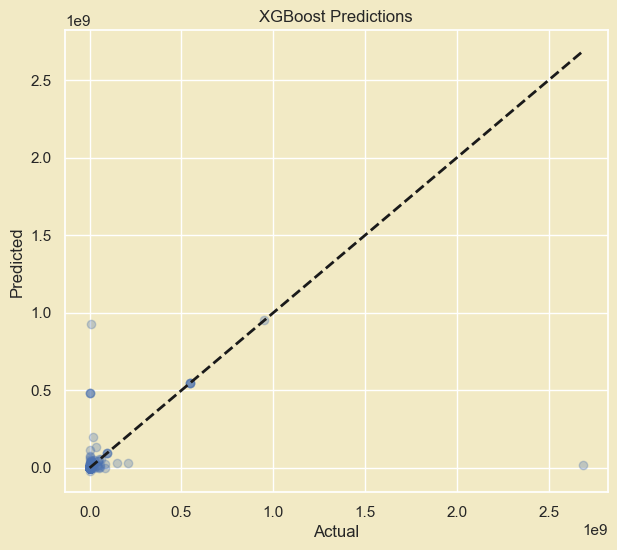

In [555]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(7, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Predictions')
plt.show()

In [556]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [557]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, posted_date, contract_type, base_type, archive_type, archive_date, set_aside_code, set_aside, response_deadline, naics_code, classification_code, pop_street_address, pop_city, pop_state, pop_zip, pop_country, active, award_number, award_date, award_amount, awardee, primary_contact_title, primary_contact_fullname, primary_contact_email, primary_contact_phone, primary_contact_fax, secondary_contact_title, secondary_contact_fullname, secondary_contact_email, secondary_contact_phone, secondary_contact_fax, organization_type, state, city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type, archive_date,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country, active,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [558]:
X_train.dtypes.to_frame('Data Type')

,Data Type
title,int64
sol_,int64
department_ind_agency,int64
cgac,int64
sub_tier,int64
fpds_code,int64
office,int64
aac_code,int64
posteddate,int64
type,int64


In [559]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

1638 row(s) have 0 missing values
Total number of rows with missing values: 0


In [560]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

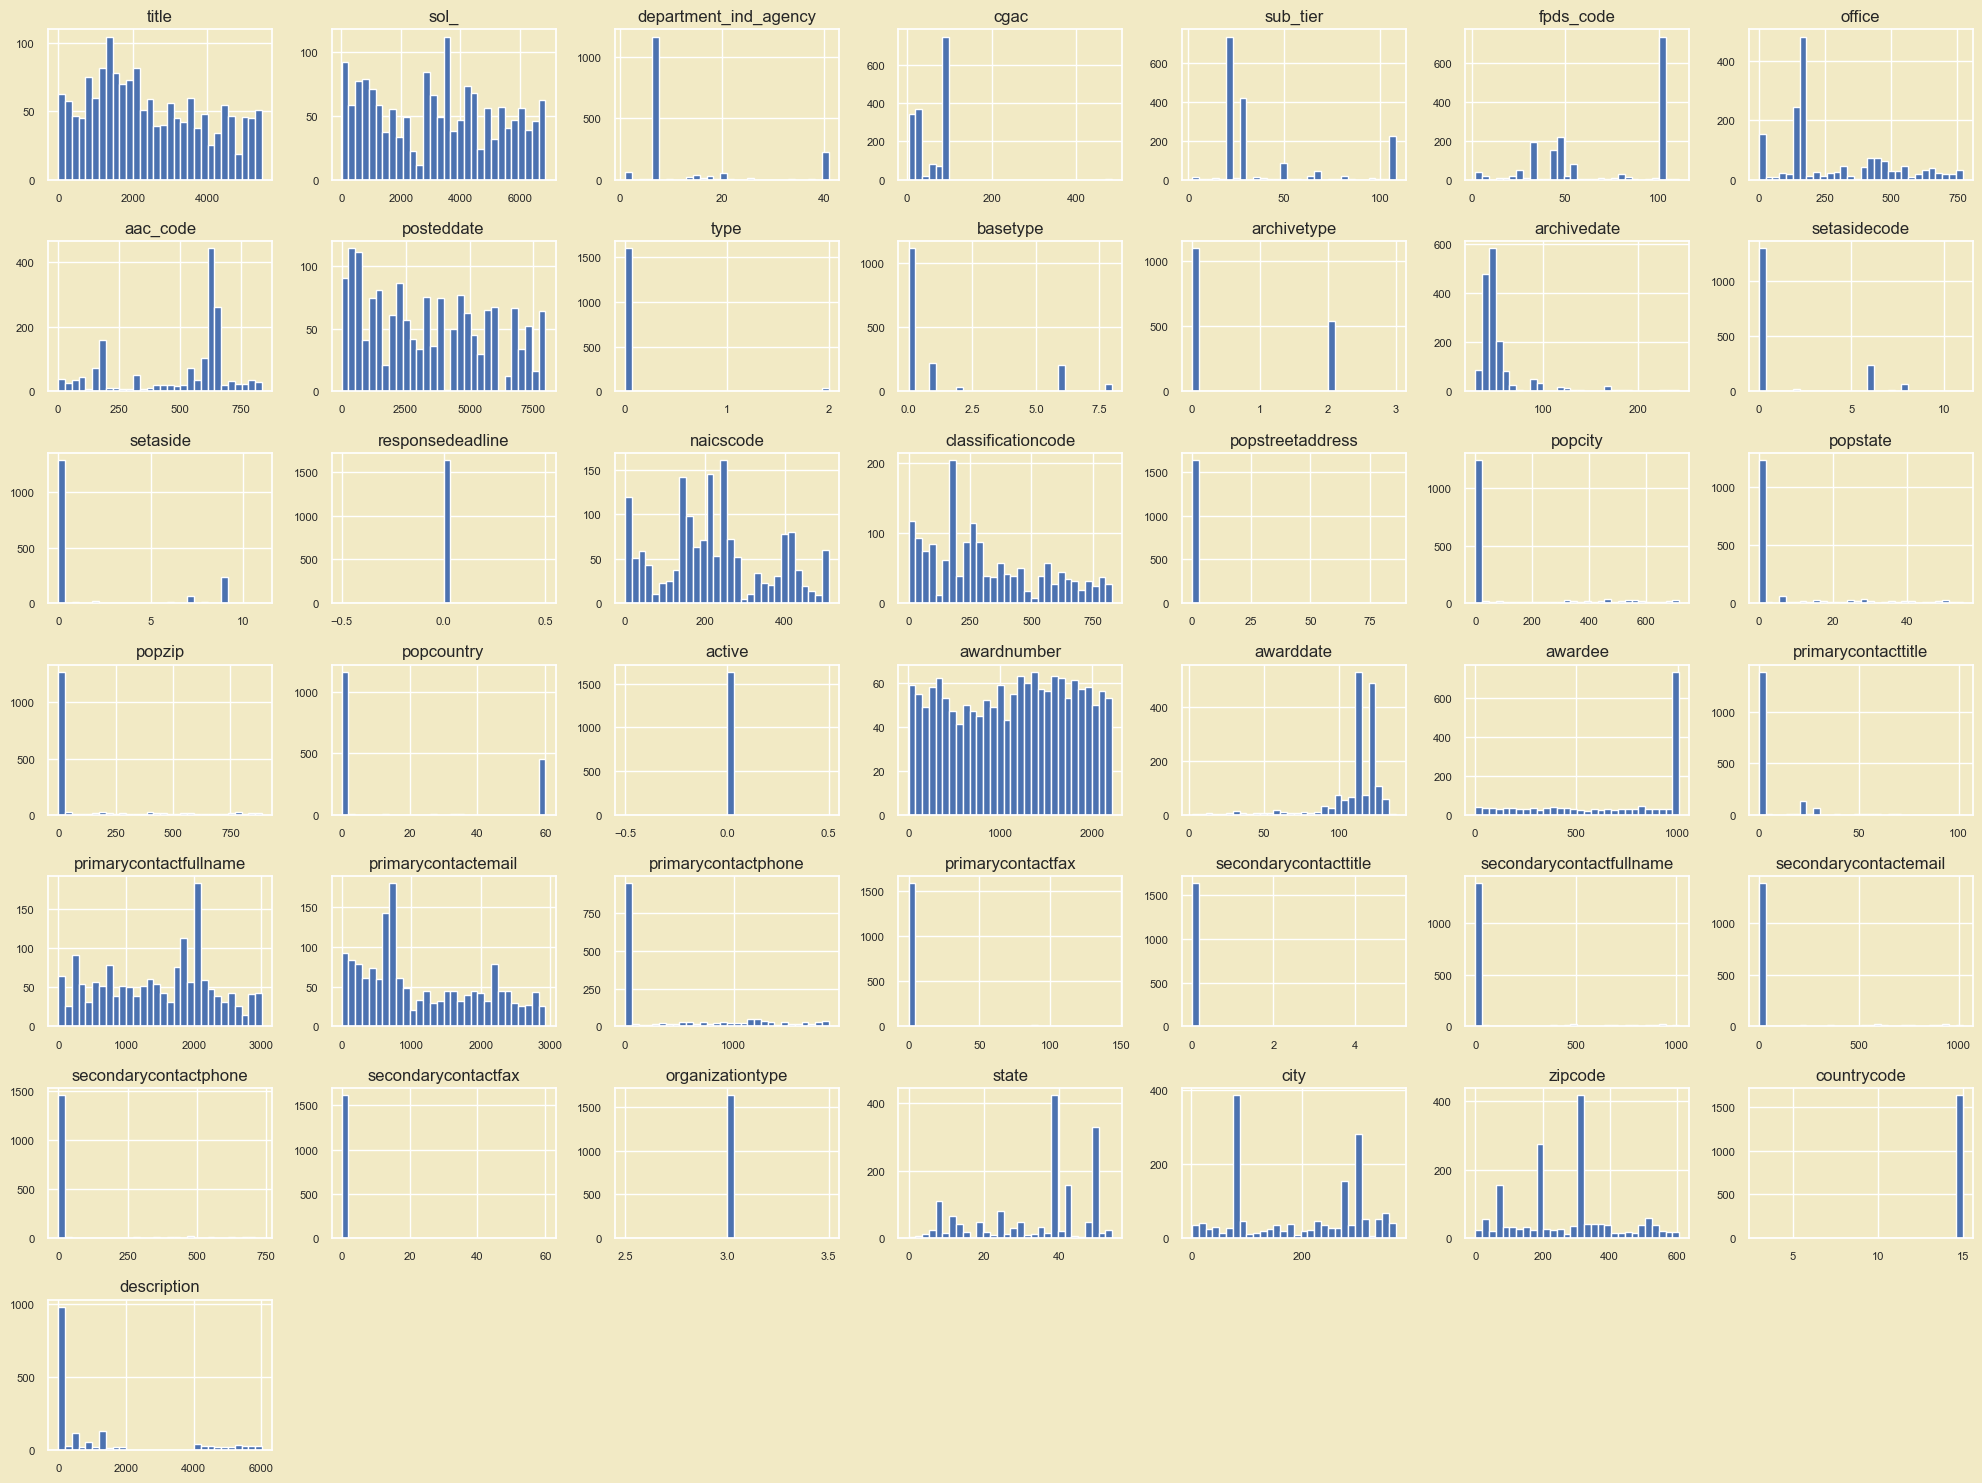

In [561]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [562]:
unique_values = X_train.nunique()
missing_values = X_train.isnull().sum()

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'Missing Values': missing_values
})

In [563]:
summary_sorted = summary.sort_values(by='Unique Values', ascending=True)

print(summary_sorted)

                          Unique Values  Missing Values
active                                1               0
organizationtype                      1               0
responsedeadline                      1               0
countrycode                           2               0
type                                  2               0
secondarycontacttitle                 3               0
popstreetaddress                      3               0
archivetype                           3               0
basetype                              6               0
setasidecode                         10               0
popcountry                           10               0
setaside                             10               0
secondarycontactfax                  16               0
department_ind_agency                21               0
cgac                                 24               0
primarycontactfax                    30               0
primarycontacttitle                  37         

In [564]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1638 entries, 7254 to 5315
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   title                     1638 non-null   int64
 1   sol_                      1638 non-null   int64
 2   department_ind_agency     1638 non-null   int64
 3   cgac                      1638 non-null   int64
 4   sub_tier                  1638 non-null   int64
 5   fpds_code                 1638 non-null   int64
 6   office                    1638 non-null   int64
 7   aac_code                  1638 non-null   int64
 8   posteddate                1638 non-null   int64
 9   type                      1638 non-null   int64
 10  basetype                  1638 non-null   int64
 11  archivetype               1638 non-null   int64
 12  archivedate               1638 non-null   int64
 13  setasidecode              1638 non-null   int64
 14  setaside                  1638 non-null   

In [565]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [566]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")

Random Forest MSE: 3.3098575287879524e+16, R2: -0.4595216493283145
Ridge Regression MSE: 3.1580249724807476e+16, R2: -0.39256924999517007


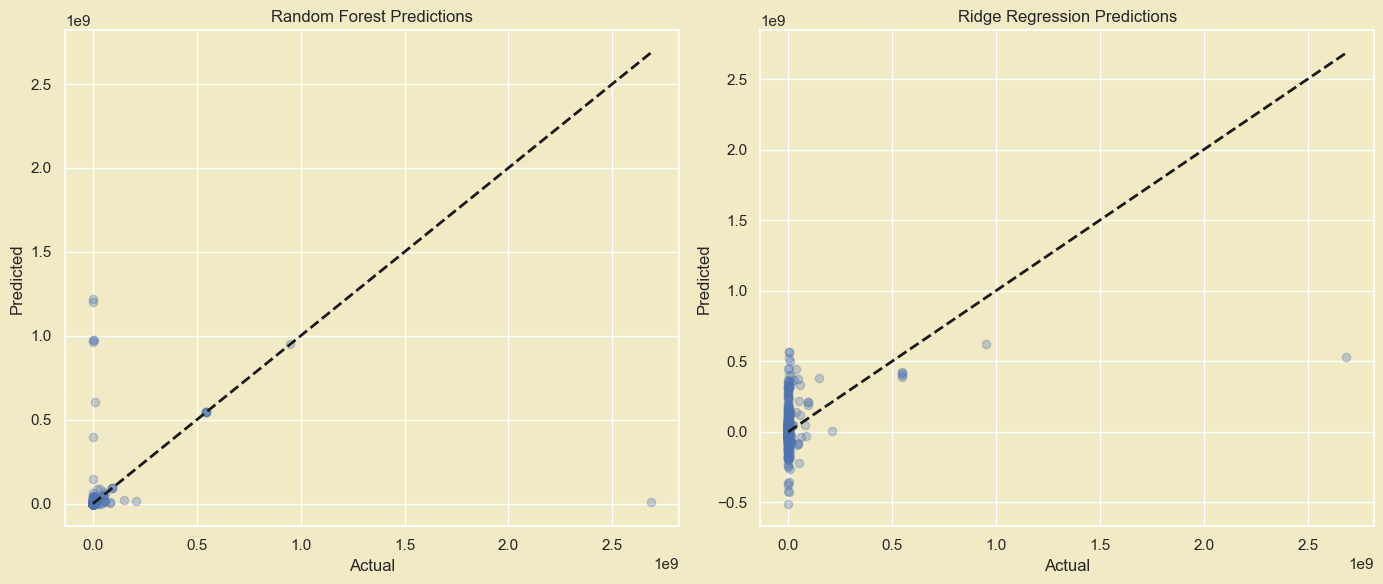

In [567]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()